In [2]:
import sys
sys.path.append('..')

In [3]:
from mesa import batch_run
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import contextlib
from competition.model import InnovationModel
from competition.agent import FirmAgent


## Single Run

In this single run, I aim to demonstrate what a typical simulation would look like by varying my research variables of interest while keeping control variables fixed. The control variables such as the number of firms, baseline success probability, TAR increment, and success probability adjustment are held constant to maintain consistency across different scenarios. The primary focus is on three key variables: average node degree, network effect, and innovation gap. These variables are varied through low, average, and high versions to observe how they influence the number of firms innovating at each step and the overall steps count.

From the plots, we can observe distinct patterns across the different scenarios. In the low version scenario, the count of innovating firms peaks early but then declines sharply before all firms have had the opportunity to innovate. This scenario also has the fewest simulation steps, indicating a faster decline in innovation activity. As the parameters increase in the average and high versions, the number of simulation steps also increases. This is likely due to the larger innovation gap, which allows more firms to continue innovating and remain competitive in the market for a longer duration. The increase in network effect and average node degree in the higher versions may promotes sustained innovation activity, leading to a more gradual decline in the number of innovating firms.

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

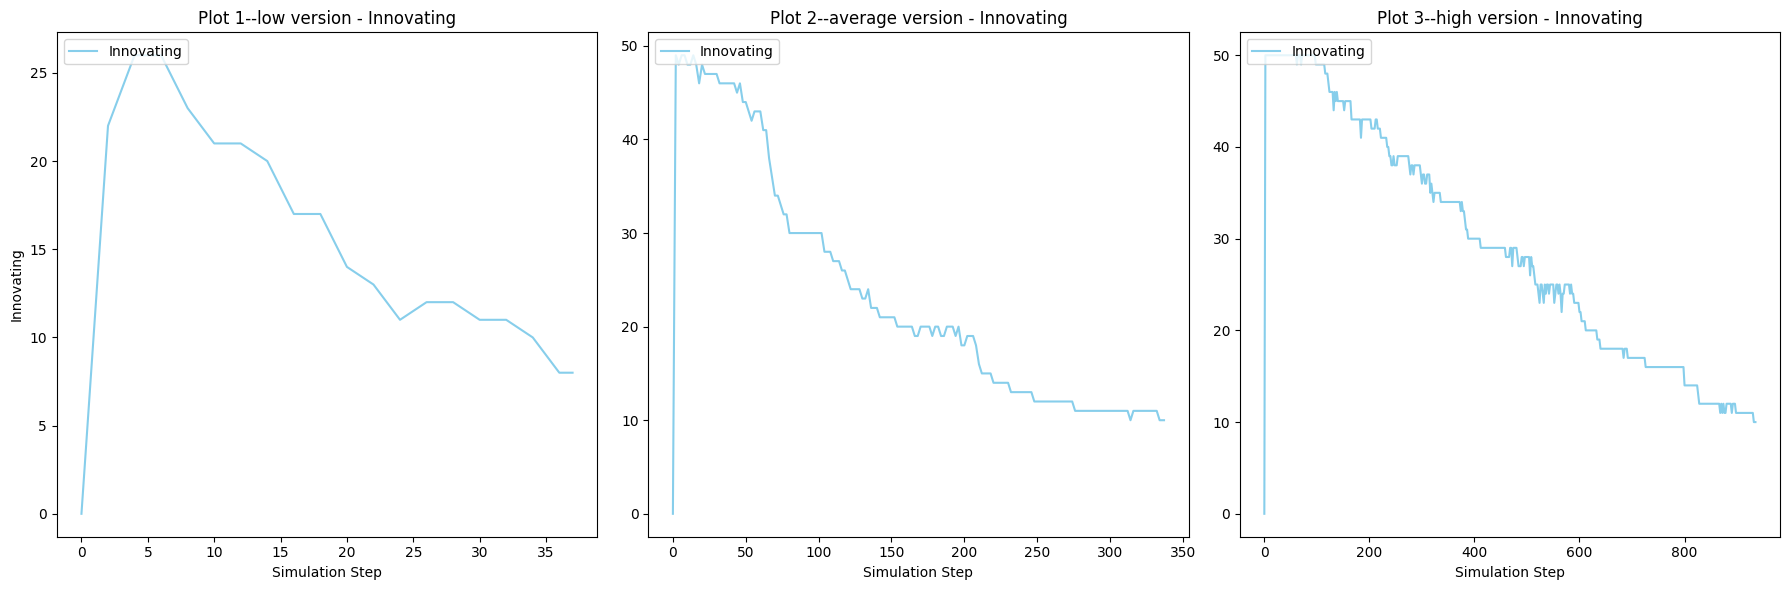

In [158]:
import os
import contextlib
import pandas as pd
import matplotlib.pyplot as plt
from mesa.batchrunner import batch_run
from competition.model import InnovationModel  

@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, "w") as devnull:
        old_stdout = os.sys.stdout
        os.sys.stdout = devnull
        try:
            yield
        finally:
            os.sys.stdout = old_stdout

parameter_sets = {
    'Plot 1--low version': {
        "num_firms": 50,
        "avg_node_degree": 3,
        "baseline_success_prob": 0.50,
        "innovation_gap": 10,
        "network_effect": 0.02,
        "distribution": "normal",
        "tar_gain": 6,
        "success_prob_adjustment": 0.08
    },
    'Plot 2--average version': {
        "num_firms": 50,
        "avg_node_degree": 5,
        "baseline_success_prob": 0.50,
        "innovation_gap": 35,
        "network_effect": 0.04,
        "distribution": "normal",
        "tar_gain": 6,
        "success_prob_adjustment": 0.08
    },
    'Plot 3--high version': {
        "num_firms": 50,
        "avg_node_degree": 8,
        "baseline_success_prob": 0.50,
        "innovation_gap": 60,
        "network_effect": 0.05,
        "distribution": "normal",
        "tar_gain": 6,
        "success_prob_adjustment": 0.08
    }
}

def run_and_plot_simulation():
    # Setup for subplots: 1 row, 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  

    for idx, (scenario, params) in enumerate(parameter_sets.items()):
        with suppress_output():
            batch = batch_run(
                InnovationModel,
                parameters=params,
                max_steps=1000,
                iterations=1,
                data_collection_period=2
            )
        
        results = pd.DataFrame(batch)

        # Plot Innovating
        axes[idx].plot(results['Step'], results['Innovating'], label='Innovating', color='#87CEEB')
        axes[idx].set_title(f'{scenario} - Innovating')
        axes[idx].set_xlabel('Simulation Step')
        if idx == 0:
            axes[idx].set_ylabel('Innovating')
        axes[idx].legend(loc='upper left')

    plt.tight_layout()  
    plt.show()

run_and_plot_simulation()


## Batch Run

In [8]:
# from contextlib import contextmanager

# @contextmanager
# def suppress_output():
#     with open(os.devnull, "w") as devnull:
#         old_stdout = os.sys.stdout
#         os.sys.stdout = devnull
#         try:
#             yield
#         finally:
#             os.sys.stdout = old_stdout
			
# params = {
#     """
#     Perform parameter sweeping to explore the effects of various parameters on the model's behavior.
    
#     Reasons for parameter sweeping selections could be checked in the paper.
#     """
#     "avg_node_degree": np.linspace(3, 6, 2),
#     "network_effect": np.linspace(0, 0.05, 5),
#     "innovation_gap": np.linspace(10, 61, 6),
#     "num_firms": [50],  # Fixed number of firms
# 	"baseline_success_prob": [0.5],
# 	"distribution": ["normal"],
#     "tar_gain": np.arange(2, 11, 4),
#     "success_prob_adjustment": np.linspace(0.02, 0.15, 3)

# }


# def run_and_collect_data():
#     with suppress_output():
#         results = batch_run(
#             InnovationModel,
#             parameters=params,
#             iterations=50,
#             number_processes=os.cpu_count() - 4
#         )
#     df = pd.DataFrame(results)
#     df.to_csv('batch_data2.csv', index=False)
#     return df


# results = run_and_collect_data()

# ## it takes 160 mins in total

  0%|          | 0/54000 [00:00<?, ?it/s]

## Analysis & Plotting

### 1. Load Data

In [161]:
df = pd.read_csv('batch_data2.csv')
df.info

<bound method DataFrame.info of          RunId  iteration  Step  avg_node_degree  network_effect  \
0            6          0    18              3.0            0.00   
1            6          0    18              3.0            0.00   
2            6          0    18              3.0            0.00   
3            6          0    18              3.0            0.00   
4            6          0    18              3.0            0.00   
...        ...        ...   ...              ...             ...   
2699995  53993         49  1000              8.0            0.05   
2699996  53993         49  1000              8.0            0.05   
2699997  53993         49  1000              8.0            0.05   
2699998  53993         49  1000              8.0            0.05   
2699999  53993         49  1000              8.0            0.05   

         innovation_gap  num_firms  baseline_success_prob distribution  \
0                  10.0         50                    0.5       normal   
1  

### 2. Summary Stats Generating & Latex prep

In [162]:
from tabulate import tabulate

## Generating a new var to better assess network influence based on the intensity(network_effect) and 
## quantity(avg_node_degree), which measures the average number of connection firms have.
df['network_influence']=df['network_effect']*df['avg_node_degree']


selected_columns = ['network_effect','avg_node_degree','network_influence', 'innovation_gap','TAR', 'tar_gain', 'success_prob_adjustment', 'Step']
summary_stats = df[selected_columns].describe()

# Convert to LaTeX table
latex_table = tabulate(summary_stats, headers='keys', tablefmt='latex')
print(latex_table)


\begin{tabular}{lrrrrrrrr}
\hline
       &   network\_effect &   avg\_node\_degree &   network\_influence &   innovation\_gap &        TAR &   tar\_gain &   success\_prob\_adjustment &       Step \\
\hline
 count &        2.7e+06   &           2.7e+06 &            2.7e+06  &          2.7e+06 &    2.7e+06 &    2.7e+06 &                 2.7e+06   &    2.7e+06 \\
 mean  &        0.025     &           5.5     &            0.1375   &         35.5     &  569.143   &    6       &                 0.085     &  425.253   \\
 std   &        0.0176777 &           1.86339 &            0.112731 &         17.4198  &  537.332   &    3.26599 &                 0.0530723 &  379.791   \\
 min   &        0         &           3       &            0        &         10       &    0       &    2       &                 0.02      &   14       \\
 25\%   &        0.0125    &           4.25    &            0.053125 &         20.2     &  127.82    &    2       &                 0.02      &   89       \\
 50\%   

### 3. Box Plots by Steps and TAR

**By Steps**

**Network Influence**: The network_influence parameter does not seem to obviously affect the simulation steps, as indicated by the similar distributions across its values. This could mean that within the studied range, network_influence does not play a critical role in determining the time to reach the event of interest.

**Innovation Gap**: In contrast, innovation_gap has a significant impact on the number of steps. Higher values of innovation_gap lead to more steps, indicating that a larger gap between the firm's TAR and the market median TAR prolongs the process. This could imply that firms with greater abilty to catch up and greater tolerance with innovation gap are more likely to keep innovating and stay in the market.

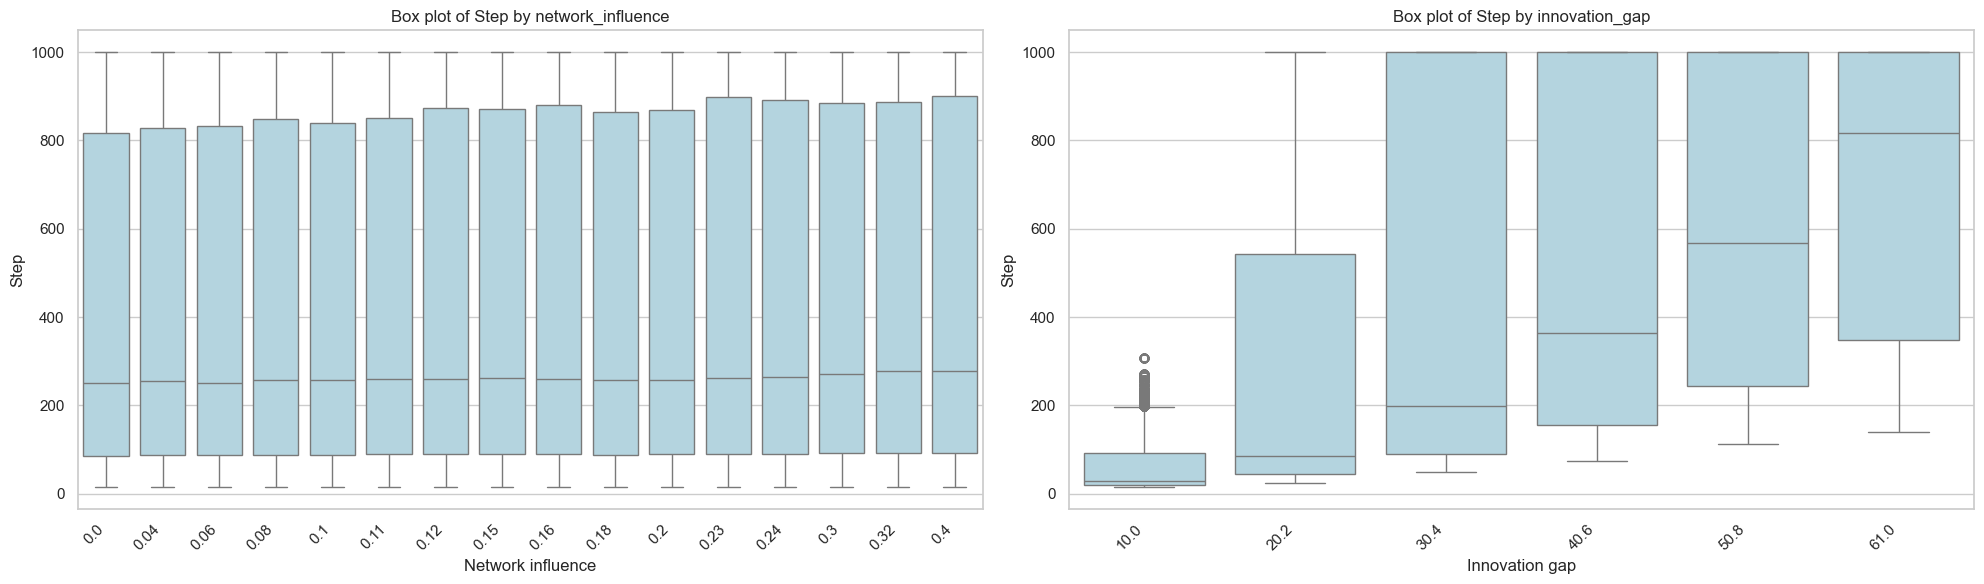

In [174]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

columns_to_plot = ['network_influence', 'innovation_gap']

# Set the Seaborn style for better aesthetics
sns.set(style="whitegrid")


plt.figure(figsize=(20, 6))

for idx, column in enumerate(columns_to_plot, 1):
    plt.subplot(1, 2, idx) 
    
    if column == 'network_influence':
        # Round the network_influence values for better readability
        df[column] = df[column].round(2)
    
    sns.boxplot(x=column, y='Step', data=df, color='lightblue')
    plt.title(f'Box plot of Step by {column}')
    plt.xlabel(column.replace('_', ' ').capitalize())  
    plt.ylabel('Step')

    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


### By TAR

**Network Influence:** From box plot of TAR by network influence, we can see there is no obvious effect on the TAR, as indicated by the similar distributions across its values.

**Innovation Gap:**  There is a clear positive relationship between the Innovation Gap and the number of steps. Larger gaps lead to TAR and greater variability, suggesting that firms with higher innovation gaps allows firms more time to adjust and catch up, resulting in longer and more diverse simulation outcomes.

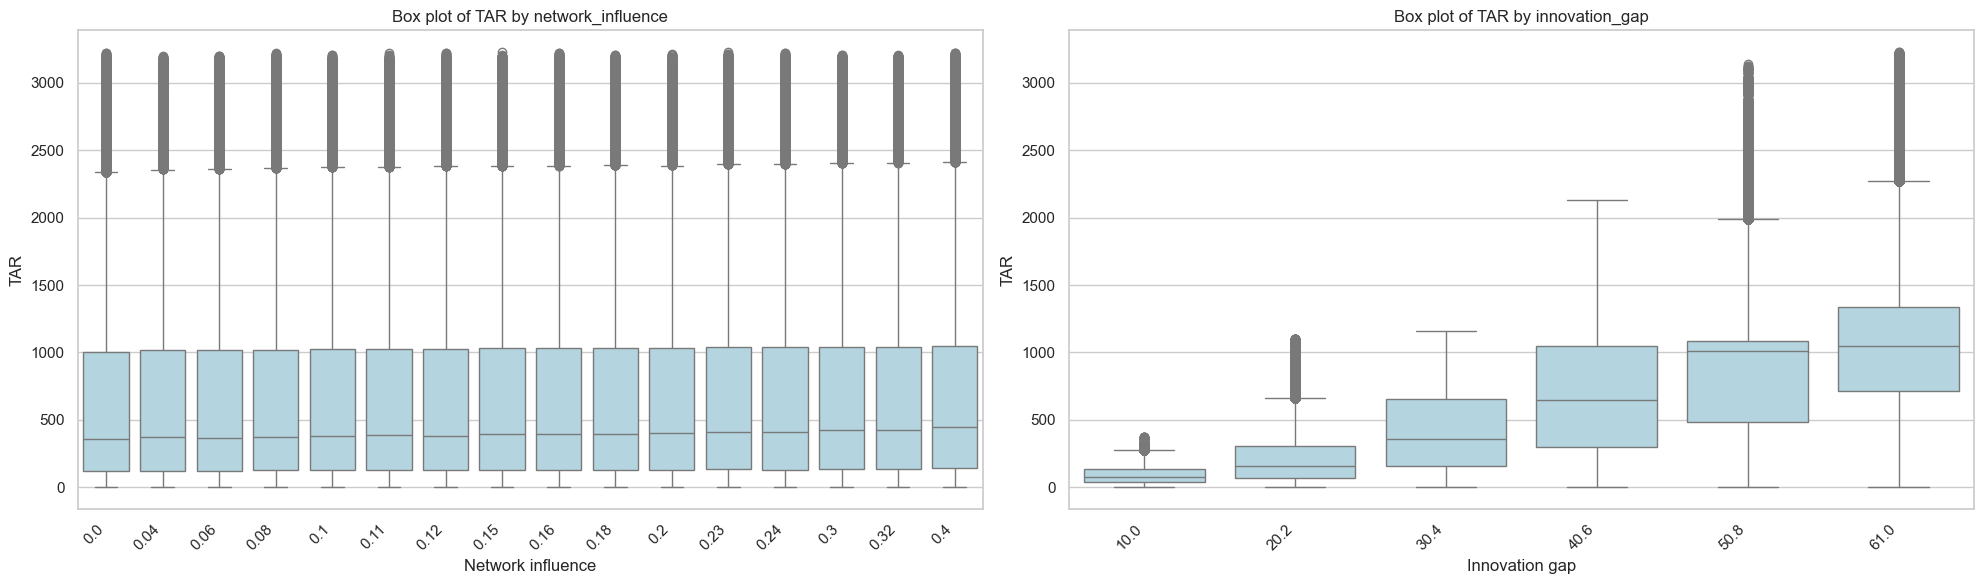

In [175]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

columns_to_plot = ['network_influence', 'innovation_gap']

# Set the Seaborn style for better aesthetics
sns.set(style="whitegrid")


plt.figure(figsize=(20, 6))

for idx, column in enumerate(columns_to_plot, 1):
    plt.subplot(1, 2, idx) 
    
    if column == 'network_influence':
        # Round the network_influence values for better readability
        df[column] = df[column].round(2)
    
    sns.boxplot(x=column, y='TAR', data=df, color='lightblue')
    plt.title(f'Box plot of TAR by {column}')
    plt.xlabel(column.replace('_', ' ').capitalize())  
    plt.ylabel('TAR')

    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


### 4. Regression Analysis 
In the previous plots, I observed that there is no obvious impact of network influence on the simulation outcomes. It is possible that the effect of network influence is being confounded by other factors within the model. To better understand the impact of network influence on the Total Aggregate Revenue (TAR), I conducted a regression analysis.

By regressing the natural logarithm of TAR (lnTAR) on network influence while controlling for other relevant factors, I can isolate the effect of network influence. This approach allows me to account for the multiplicative nature of the relationships in the data and mitigate the impact of outliers or skewed distributions. The control variables included in the regression are innovation gap, tar gain, success probability adjustment, and simulation step. This analysis aims to provide a clearer understanding of how network influence affects TAR when other variables are held constant.

I aggregate the data by RunId. This is because TAR varies for each firm, but other variables, such as network influence, innovation gap, tar gain, success probability adjustment, and the simulation step, are collected at the end of the simulation and are constant for all firms within a given simulation run.

By grouping the data by RunId and aggregating the relevant variables, I can summarize the total TAR on market level, which provides a clearer picture of the overall effects.

In [133]:
# Aggregate the total TAR for each simulation run
aggregated_data = df.groupby('RunId').agg({
    'network_influence': 'mean', 
    'innovation_gap': 'mean',    
    'tar_gain': 'mean',          
    'success_prob_adjustment': 'mean',
    'TAR': 'sum',                
    'Step': 'mean',               
	'iteration':'mean'
}).reset_index()

# Renaming the columns for clarity
aggregated_data.rename(columns={'TAR': 'Total_TAR', 'Step': 'Step_count'}, inplace=True)
aggregated_data['lnTAR']=np.log(aggregated_data['Total_TAR'])

In [137]:
import statsmodels.api as sm

# Select relevant features and the outcome variable
features = ['network_influence', 'innovation_gap', 'tar_gain','Step_count' ,'success_prob_adjustment']
X = aggregated_data[features]
y = aggregated_data['lnTAR']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': aggregated_data['iteration']})

# Print the summary of the model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  lnTAR   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                 2.861e+06
Date:                Wed, 22 May 2024   Prob (F-statistic):          1.23e-132
Time:                        18:02:35   Log-Likelihood:                 734.25
No. Observations:               54000   AIC:                            -1457.
Df Residuals:                   53994   BIC:                            -1403.
Df Model:                           5                                         
Covariance Type:              cluster                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

**Interpretation of Regression Results:** 

**Network Influence:** The coefficient for network influence is 0.1907, which is positive and highly significant (p-value = 0.000). This indicates that for each unit increase in network influence, lnTAR increases by approximately 0.1907 units, holding other factors constant. This result is consistent with the expectation that network influence positively impacts technological advancement and innovation. The positive sign makes sense as network influence can facilitate the copying and sharing of technology among firms, leading to higher success probabilities in innovation and, consequently, greater technological advancements.

**Innovation Gap, TAR Gain, Step Count:** As expected, they all have positive significant coefficient, indicating that they are sinificantly contributing to tech advancement in the simulation.

**Success Probability Adjustment:** The coefficient for success probability adjustment is -0.0024, which is not statistically significant (p-value = 0.754). This indicates that variations in the adjustment of success probability do not have a significant impact on lnTAR in this model. This make sense as this adjustment is postive when firm successfully innovate but negative when fail to innovate.